# Binoculars

Binoculars is a visual debugging tool for automation supervision in Jupyter Lab environments. It provides real-time visual feedback during automation runs by displaying screenshots, target areas, and detailed step information.

## Core Concept

When running automation scripts, Binoculars captures and displays:
- The last screenshot taken during automation
- The target bitmap that was searched for
- Step-by-step descriptions of the automation process
- Any errors that occurred during execution

## Basic Usage

```python
from binoculars import Binoculars

# Initialize the viewer
viewer = Binoculars(width=400)

# During automation:
viewer.image1 = screenshot  # Set the main screenshot
viewer.image2 = target_image  # Set the target image
viewer.description.value = "Searching for login button..."
```

## Technical Details

Binoculars uses IPython widgets to create an interactive display consisting of:
- A description panel showing the current automation step
- Two image panels showing the screenshot and target image
- An error panel for displaying any issues

The display automatically updates as new images and descriptions are set, making it ideal for monitoring long-running automation tasks.

## Error Handling

Binoculars includes built-in error visualization:
- Generates a distinctive error image when images fail to load
- Displays error messages in a dedicated panel
- Maintains visual consistency even during failures

## Limitations

- Only works in Jupyter Lab/Notebook environments
- Requires IPython widget support
- Image display limited to PNG format

In [16]:
from ipywidgets import widgets
from IPython.display import display as ipython_display
from pyperiscope import Scope
from PIL import Image, ImageDraw, ImageFont
import io
import markdown
import pickle
import dill
import pyautogui
import time
import pyperclip

class Binoculars:
    def __init__(self, width=400):
        self.width = width
        self.image1 = None
        self.image2 = None
        self.box = None
        self.image = None
        self.error_image = self._create_error_image(320,320)
        self._create_widgets()

    def _create_error_image(self, width, height):
        # Create black background image
        img = Image.new('RGB', (width, height), color='black')
        draw = ImageDraw.Draw(img)
        
        # Draw gray cross
        gray = (128, 128, 128)
        cross_width = max(2, min(width, height) // 100)  # Dynamic line width
        # Horizontal line
        draw.line((0, height//2, width, height//2), fill=gray, width=cross_width)
        # Vertical line
        draw.line((width//2, 0, width//2, height), fill=gray, width=cross_width)
        
        # Add text
        text = "Image could not be loaded"
        try:
            # Try to load a common font
            font = ImageFont.truetype("arial.ttf", size=min(width, height)//15)
        except:
            # Fallback to default font
            font = ImageFont.load_default()
        
        # Calculate text position
        text_bbox = draw.textbbox((0, 0), text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        x = (width - text_width) // 2
        y = (height - text_height) // 2
        
        # Draw white text with black border for better visibility
        draw.text((x, y), text, fill='white', font=font, stroke_width=2, stroke_fill='black')
        
        return img   

    def _create_widgets(self):
        """Initialize all widgets including text areas"""
        # Create description text widget (Markdown)
        self.description = widgets.HTML(
            value='',
            placeholder='Description',
            description='',
        )
        
        # Create image widgets
        self.widget1 = widgets.Image(format='png', width=self.width)
        self.widget2 = widgets.Image(format='png', width=self.width)
        self.image_box = widgets.VBox([self.widget1, self.widget2])
        
        # Create error text widget (Markdown)
        self.error_text = widgets.HTML(
            value='',
            placeholder='Error messages',
            description='',
        )
        
        # Stack all widgets vertically
        self.box = widgets.VBox([
            self.description,
            self.image_box,
            self.error_text
        ])
        
        ipython_display(self.box)

    def _convert_to_bytes(self, pil_image):
        """Convert PIL image to bytes"""
        buf = io.BytesIO()
        pil_image.save(buf, format='PNG')
        return buf.getvalue()

# Enhanced Binoculars

An extended version of the Binoculars class that adds markdown support and simplified image management for automation supervision.

## Core Concept

This enhanced version provides:
- Automatic error image initialization
- Markdown formatting for descriptions and errors
- Simplified dual image updates
- Type checking for image inputs

## Basic Usage

```python
from binoculars import Binoculars

# Initialize with default error images
viewer = Binoculars(width=400)

# Update both images simultaneously
viewer.update_both(screenshot, target_image)

# Set step description with markdown
viewer.set_description("# Searching for Login Button\n- Scanning top menu")

# Set error message if needed
viewer.set_error("**Error**: Target not found")
```

## Technical Details

The enhanced Binoculars extends the base class with:
- Automatic initialization of error images
- Strict PIL Image type checking
- Markdown to HTML conversion for text displays
- Synchronized image updates

## Key Methods

- `update_both(image1, image2)`: Updates both display panels simultaneously
- `set_description(text)`: Sets markdown-formatted description
- `set_error(text)`: Sets markdown-formatted error message

## Input Requirements

- Images must be PIL Image objects
- Description and error text support markdown formatting
- Null text inputs are handled gracefully

In [17]:
class Binoculars(Binoculars):
    def __init__(self, width=400):
        super().__init__(width)
        self.update_both(self.error_image, self.error_image)
        self.set_description("# No step loaded")
        
    def update_both(self, image1, image2):
        """Update both images at once"""
        if not isinstance(image1, Image.Image) or not isinstance(image1, Image.Image):
            raise TypeError("Inputs must be a PIL Image")

        image1_bytes = self._convert_to_bytes(image1)
        image2_bytes = self._convert_to_bytes(image2)
        self.widget1.value = image1_bytes
        self.widget2.value = image2_bytes
    
    def set_description(self, text):
        """Update description text with markdown formatting"""
        # Convert markdown to HTML
        if not text == None:
            md = markdown.Markdown()
            self.description.value = md.convert(text)
    
    def set_error(self, text):
        """Update error text with markdown formatting"""
        # Convert markdown to HTML with red color for errors
        if not text == None:
            md = markdown.Markdown()
            self.error_text.value = md.convert(text)

# Debug Binoculars

A debugging extension of Binoculars that enables post-mortem analysis of automation screenshots with embedded metadata.

## Core Concept

Debug Binoculars extracts serialized debugging data from image metadata to reconstruct the automation state at the time of failure. This allows for detailed analysis of automation issues by examining:
- The exact screenshot when an issue occurred
- Scope configuration and target areas
- Mouse positions and offsets
- Error states and documentation

## Basic Usage

```python
from binoculars import Binoculars

viewer = Binoculars()
viewer.debug_screenshot("failed_step_screenshot.png")

# The step object is now available globally for inspection or modification
step.found_locations  # Access found locations
```

After loading a debug screenshot, the Scope object becomes available as a global variable named `step`. This allows for:
- Direct inspection of the automation state as in creation time
- Interactive testing of different parameters
- Modification of search areas and offsets
- Coninue where the worklow died

## Technical Details

The debug extension works by:
- Loading PNG images with embedded metadata
- Deserializing step configuration and state data
- Reconstructing Scope objects for visualization
- Rendering both the target and actual screenshot areas
- Displaying relevant error messages and documentation

## State Recovery

Debug Binoculars recovers:
- Step configuration
- Current step index
- Last error message
- Documentation string
- Found locations and offsets
- Mouse and area positioning

## Error Handling

The debugger handles various failure scenarios:
- Missing or corrupt metadata
- Invalid serialized data
- Missing location data
- Scope reconstruction failures

## Limitations

- Requires specially prepared PNG files with embedded metadata
- Metadata must be serialized using pickle
- Dependent on Scope class for visualization
- Cannot modify historical data

In [18]:
class Binoculars(Binoculars):
    def debug_screenshot(self, filepath):
        global step
        image = Image.open(filepath)
        
        try:
            # Extract serialized data from metadata
            serialized_data = bytes.fromhex(image.info.get("custom_data", ""))
            data_dict = pickle.loads(serialized_data)
        except (KeyError, pickle.UnpicklingError):
            data_dict = {}  # Return empty dict if no valid data found

        if not data_dict == {}:
            step = Scope(saved_dict=data_dict['step'])
            self.current_step = data_dict['current_step']
            self.last_error = data_dict['last_error']
            self.current_doc = data_dict['current_doc']
            # update UI
            try:
                step.found_locations = data_dict['last_found']
                current = Scope(mouse_offset=step.found_locations[0]['mouse_offset'], area_offset=step.area_offset, area_size=step.area_size, saved_image=image)
                self.update_both(step.render_preview(), current.render_preview())
                self.set_description(self.current_doc)
                self.set_error(self.last_error)
            except:
                self.update_both(step.render_preview(), self.error_image)
                self.set_description(self.current_doc)
                self.set_error(self.last_error)

# FileWatcher

FileWatcher is a robust monitoring system designed to work with Binoculars for real-time automation supervision. It monitors a sequence of screenshot files and updates the Binoculars display as new automation steps are completed.

## Core Concept

FileWatcher continuously monitors for sequentially numbered PNG files (e.g., `base-0.png`, `base-1.png`). When a new file is detected and fully written, it triggers Binoculars to update its display with the latest automation state.

## Technical Details

FileWatcher employs several mechanisms to ensure reliable file monitoring:
- Thread-based monitoring for non-blocking operation
- File size stabilization detection
- Image validation before processing
- Sequential file numbering for step tracking
- Automatic error recovery and continuation

## File Naming Convention

Files are expected to follow the pattern:
```
{base_path}-{index}.png
```
For example: `automation_step-0.png`, `automation_step-1.png`

## Robustness Features

- Waits for files to be completely written
- Validates image integrity before processing
- Handles truncated images gracefully
- Continues monitoring even after errors
- Thread-safe operations with lock mechanism

## Limitations

- Only monitors PNG files
- Requires sequential file numbering
- Files must maintain specified naming pattern
- 5-second timeout for file stabilization

In [19]:
import os
import threading
import time
from PIL import Image, ImageFile

# Enable truncated image loading
ImageFile.LOAD_TRUNCATED_IMAGES = True

class FileWatcher:
    """Robust file watcher with write completion detection"""
    def __init__(self, binoculars, base_path):
        self.binoculars = binoculars
        self.base_path = base_path
        self.current_index = 0
        self.running = False
        self.thread = None
        self.lock = threading.Lock()

    def get_current_path(self):
        return f"{self.base_path}-{self.current_index}.png"

    def start(self):
        self.running = True
        self.thread = threading.Thread(target=self.monitor_sequence)
        self.thread.daemon = True
        self.thread.start()

    def stop(self):
        self.running = False
        if self.thread:
            self.thread.join()

    def monitor_sequence(self):
        while self.running:
            current_path = self.get_current_path()
            if self._wait_for_file(current_path):
                try:
                    with self.lock:
                        self.binoculars._update_from_screenshot(current_path)
                        self.current_index += 1
                        print(f"Waiting for {self.get_current_path()}")
                except Exception as e:
                    print(f"Error processing {current_path}: {str(e)}")
                    self.current_index += 1  # Prevent blocking
            else:
                time.sleep(0.1)

    def _wait_for_file(self, path, timeout=5):
        """Wait for file to stabilize and become readable"""
        start_time = time.time()
        last_size = -1
        stable_count = 0

        while time.time() - start_time < timeout:
            try:
                current_size = os.path.getsize(path)
                if current_size == last_size:
                    stable_count += 1
                    if stable_count > 3:  # 300ms stability
                        if self._validate_image(path):
                            return True
                else:
                    last_size = current_size
                    stable_count = 0
                time.sleep(0.1)
            except FileNotFoundError:
                time.sleep(0.1)

        return False

    def _validate_image(self, path):
        """Verify image can be loaded"""
        try:
            with Image.open(path) as img:
                img.verify()
            return True
        except Exception:
            return False

# Monitoring Binoculars

An extension of Binoculars that provides real-time monitoring capabilities through integration with FileWatcher. This version automatically updates the display as new automation screenshots become available.

## Core Concept

Monitoring Binoculars adds automated screenshot monitoring by:
- Processing screenshot files with embedded metadata
- Updating the display with step information and error states
- Managing FileWatcher lifecycle

## Technical Details

The monitoring system processes screenshot metadata containing:
- Scope configuration and state
- Found target locations
- Mouse and area offsets
- Documentation and error messages

Each screenshot update triggers:
- Metadata extraction and deserialization
- Scope object reconstruction
- Preview rendering for both target and result
- UI updates for description and error panels

## Usage

```python
viewer = Binoculars()

# Start monitoring
viewer.start_monitoring("automation_step")

# Stop monitoring when needed
viewer.watcher.stop()
```

## Error Handling

The system provides robust error handling:
- Defaults to error images when data loading fails
- Maintains descriptive error messages
- Continues monitoring despite individual file failures
- Preserves display consistency during errors

## Limitations

- Requires specially formatted PNG files
- Metadata must follow expected dictionary structure
- Dependent on Scope class for visualization
- Single active monitoring session per instance

In [20]:
class Binoculars(Binoculars):
    def _update_from_screenshot(self, filepath):
        image = Image.open(filepath)
        
        try:
            # Extract serialized data from metadata
            serialized_data = bytes.fromhex(image.info.get("custom_data", ""))
            data_dict = pickle.loads(serialized_data)
        except (KeyError, pickle.UnpicklingError):
            data_dict = {}  # Return empty dict if no valid data found

        # set default values
        left_image = self.error_image
        right_image = self.error_image
        description = str(filepath)[-4:]+"ERROR loading data"
        error_desc =  "could not read the data portion from: "+str(filepath)

        # try to override the values with actual data
        if not data_dict == {}:
            step = Scope(saved_dict=data_dict['step'])
            step.found_locations = data_dict['last_found']
            #self.current_step = data_dict['current_step']
            last_error = data_dict['last_error']
            #self.scope_cell_id = data_dict['scope_cell_id']
            current_doc = data_dict['current_doc']
            current = Scope(mouse_offset=step.found_locations[0]['mouse_offset'], area_offset=step.area_offset, area_size=step.area_size, saved_image=image)
            left_image = step.render_preview()
            right_image = current.render_preview()
            if current_doc:
                description = current_doc
            if last_error:
                error_desc = last_error
            
        # update UI
        self.update_both(left_image, right_image)
        self.set_description(current_doc)
        self.set_error(last_error)
        
    def start_monitoring(self, filepath):
        print("to stop the monitoring use Bincoulars_instance.watcher.stop()")
        if hasattr(self, 'watcher'):
            self.watcher.stop()
        self.watcher = FileWatcher(self, filepath)
        self.watcher.start()

In [21]:
b = Binoculars()

In [23]:
b.debug_screenshot("_dav_subtitle2.png")

AttributeError: 'ImageNotFoundException' object has no attribute 'strip'

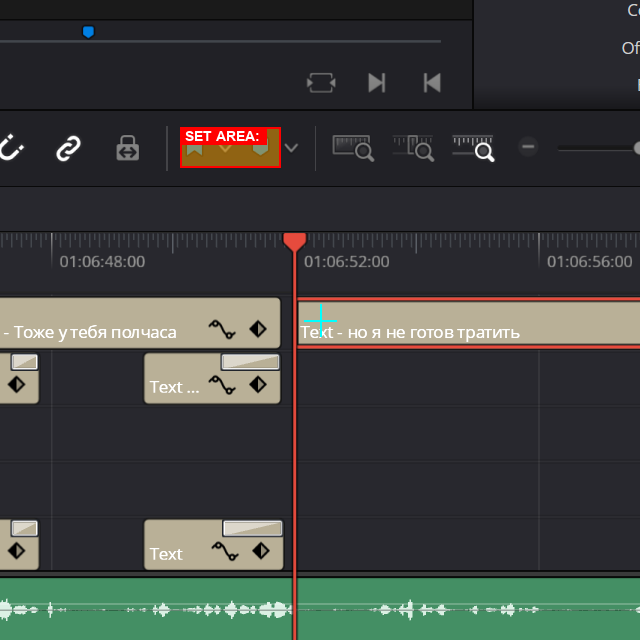

In [26]:
step.render_preview()

In [2]:
%pip install markdown

Note: you may need to restart the kernel to use updated packages.
